# Getting from the DarkNews generator to the detector geometry

In [92]:
from DarkNews import const
from DarkNews import Cfourvec as Cfv
import DarkNews as dn
from DarkNews import GenLauncher
import importlib.resources as resources
import matplotlib.pyplot as plt
import plotly as plotly
import numpy as np
from numpy.random import choice
import pandas as pd
import plotly.express as px
from plotly.graph_objects import Layout
import uproot

# import geometry_functions  as gf
# Set the source directory, where flux and other files are stored (and cannot be hosted 
# on Github). The path on /exp/uboone/app should be accessible to uBooNE users. 
source_dir = "./source/"

## Defining the NuMI geometry and parameters

In [93]:
# Defining NuMI beam parameters in cm
NuMI_decay_pipe_radius = 1e2 # cm, from https://ar5iv.labs.arxiv.org/html/1507.06690
NuMI_decay_pipe_length = 675e2 # cm, from https://ar5iv.labs.arxiv.org/html/1507.06690
NuMI_full_length = 10e2 + 30e2 + NuMI_decay_pipe_length + 2.5e2 # cm, corresponding to 10m horn 1, 30m horn 2, 675m decay pipe, 2.5m absorber

NuMI_target = [0,0,0]
NuMI_absorber = [0,0, NuMI_full_length]

# Timing offsets defined in uboone docdb 12290
uBNuMIGlobalTimeOffset = 4687.5
uBNuMIRandomTimeOffset = 9600

# Matrix to convert from NuMI beam cooridinates to the uBooNE detector coordinates
numi_coord_matrix =    np.array([
                        [ 0.9210385380402568, 0.0227135048039241207, 0.38880857519374290 ],
	                    [0.0000462540012621546684, 0.99829162468141475, -0.0584279894529063024],
                        [-0.38947144863934974, 0.0538324139386641073, 0.91946400794392302 ]
                        ])

def convert_to_numi_beam_coords(x):
    matrix = np.linalg.inv(numi_coord_matrix)
    x = np.array(x)
    x = np.matmul(matrix,x.T).T
    x += ub_beam_coords
    return x

def convert_to_ub_tpc_coords(x):
    x = np.array(x)
    x -= ub_beam_coords
    x = np.matmul(numi_coord_matrix,x.T).T
    return x

# Position of the uBooNE detector in NuMI beam coordinates
ub_beam_coords = np.array([5502, 7259, 67270]) # cm

# Timing offsets defined in uboone docdb 12290
uBNuMIGlobalTimeOffset = 4687.5
uBNuMIRandomTimeOffset = 9600

# Importing NuMI flux files
# Energy vs baseline distribution
NuMI_energies_positions = np.genfromtxt(source_dir+'Fluxes/NuMI_energy_distances.dat', delimiter=' ', skip_header=0)
NuMI_energy_nu = NuMI_energies_positions[1:,0]
NuMI_distances_nu = NuMI_energies_positions[0,1:]
NuMI_e_vs_dist = NuMI_energies_positions[1:,1:]
NuMI_enu_max = np.max(NuMI_energy_nu)
# Angle-energy flux normalization
NuMI_fluxes = np.genfromtxt(source_dir+'Fluxes/NuMI_angle_energy_normalization.dat', delimiter=' ', skip_header=0)
NuMI_e_bins_angle = NuMI_fluxes[1:,0]
NuMI_th_bins_angle = NuMI_fluxes[0,1:]
NuMI_e_vs_angle = NuMI_fluxes[1:,1:]
# Neutrino angle (from NuMI beam) distribution
NuMI_angle_dist = np.genfromtxt(source_dir+'Fluxes/NuMI_angle_flux.dat', delimiter=' ', skip_header=0)
NuMI_angle_bins = NuMI_angle_dist[0,:]
NuMI_angle_dist = NuMI_angle_dist[1,:]

angle_flux_min = minval = np.min(NuMI_angle_dist[np.nonzero(NuMI_angle_dist)])
NuMI_angle_dist = NuMI_angle_dist / angle_flux_min

file_run0 = uproot.open(source_dir+'Root/output_uboone_fhc_run0_set1.root')
base_line_hist = file_run0['numu/Detsmear/Baseline_numu_CV_TPC;1']
baseline_hist, baseline_bins = base_line_hist.to_numpy()

## Defining the MicroBooNE/NuMI geometry

This follows the implementation in dn.geom for the MicroBooNE cryostat

In [94]:
# These functions are taken from the DarkNews repo, and adapted where necessary.
# https://github.com/mhostert/DarkNews-generator
################## ROTATION FUNCTIONS ######################
def dot3(p1, p2):
    return p1[0]*p2[0] + p1[1]*p2[1] + p1[2]*p2[2]

def normalize_3D_vec(v):
    return v / np.sqrt(dot3(v,v))

def cross3(p1, p2):
    px = p1[1]*p2[2] - p1[2]*p2[1]
    py = p1[2]*p2[0] - p1[0]*p2[2]
    pz = p1[0]*p2[1] - p1[1]*p2[0]
    return np.array([px,py,pz])

# rotate v by an angle of theta on the plane perpendicular to k using Rodrigues' rotation formula
def rotate_by_theta(v,k,theta):
    # we first normalize k
    k = normalize_3D_vec(k)
    
    # Rodrigues' rotation formula
    return np.cos(theta) * v + np.sin(theta) * cross3(k,v) + dot3(k,v) * (1 - np.cos(theta)) * k


# rotate a 3D-vector v using the same minimum rotation to take vector a into vector b
def rotate_similar_to(v,a,b):
    # normalize vectors a and b
    a = normalize_3D_vec(a)
    b = normalize_3D_vec(b)
    
    # compute normal vector to those and angle
    k = cross3(a,b)
    theta = np.arccos(dot3(a,b))
    
    # use previous function to compute new vector
    return rotate_by_theta(v,k,theta)

def rotate_dataframe(df):
    particles = ['P_target','P_recoil','P_decay_N_parent','P_decay_ell_plus','P_decay_ell_minus','P_decay_N_daughter','P_decay_photon','P_projectile']

    for particle in particles:
        try:
            df.loc[:,(particle,['1','2','3'])] = rotate_similar_to(df[particle].to_numpy().T[1:],df.P_projectile.to_numpy().T[1:],df.pos_scatt.to_numpy().T[1:] - df['pos_prod'].to_numpy().T).T
        except:
            continue

    return df

def nearest_point_to_ub(scatt_pos):

    beam_vec = np.subtract(NuMI_absorber, NuMI_target)
    beam_hat = beam_vec / np.linalg.norm(beam_vec)

    BNB_vec = np.array([[0,0,0],[0,0,1]])
    BNB_vec = convert_to_numi_beam_coords(BNB_vec)
    BNB_vec = np.subtract(BNB_vec[1], BNB_vec[0])

    # Get the point on the beam closest to the scattering point
    p1_vec = scatt_pos - NuMI_target
    p1_len = np.linalg.norm(p1_vec)
    p1_hat = p1_vec / p1_len

    cos_theta = np.dot(p1_hat, beam_hat)
    scale = cos_theta * p1_len
    scale = np.tile(scale, (3,1)).T

    return (beam_hat * scale)


def neutrino_nan(E_nu):
    final_angles = []
    for i in range(len(E_nu)):
        e_bins = np.searchsorted(NuMI_e_bins_angle, E_nu[i], side='right')-1
        probs_angle = np.ones_like(NuMI_e_vs_angle)

        for j in range(np.shape((probs_angle))[1]):
            arr = np.asarray([NuMI_e_vs_angle.T[:,e_bins]])
            if arr.sum() != 0:
                probs_angle[j] = arr
        neutrino_angle = choice(NuMI_th_bins_angle, 1, p=probs_angle[e_bins] / probs_angle[e_bins].sum())[0]
        final_angles.append(neutrino_angle)
    return final_angles

def neutrino_random(angle,E_nu):
    e_bins = np.searchsorted(NuMI_e_bins_angle, E_nu, side='right')-1
    angle_hist = NuMI_e_vs_angle.T[:,e_bins]

    th_bin_1 = np.searchsorted(NuMI_angle_bins, angle, side='right')-1
    th_bin_2 = np.searchsorted(NuMI_angle_bins, 180-angle, side='right')-1

    th_arr = []
    weight_arr = []
    
    search_range = 9
    offset = search_range//2 +1
    for j in range(search_range):
        th_arr.append(NuMI_angle_bins[th_bin_1 +j - 4])
        th_arr.append(NuMI_angle_bins[th_bin_2 +j - 4])
        
        weight_arr.append(NuMI_angle_dist[th_bin_1 +j - 4])
        weight_arr.append(NuMI_angle_dist[th_bin_2 +j - 4])

    th_arr = np.array(th_arr).T
    weight_arr = np.array(weight_arr).T

    sum = np.sum(weight_arr, axis=1)
    sum = np.tile(sum, (2*search_range, 1)).T
    weights = np.array(weight_arr) / sum

    if np.isnan(weights).any():
        print(weights)
    else: print('success')

    th_arr = np.array(th_arr)
    return  [choice(th_arr[i], 1, p=weights[i])[0] for i in range(len(E_nu))]

def neutrino_nan_random_split(angle, E_nu):
    return np.where(np.isnan(angle) == True, neutrino_nan(E_nu), neutrino_random(angle, E_nu))


def get_neutrino_angle(scatt_pos, length, E_nu):

    scatt_pos = convert_to_numi_beam_coords(scatt_pos)
    nearest_point = nearest_point_to_ub(scatt_pos)
    
    dist = np.linalg.norm(scatt_pos - nearest_point, axis=1)

    sin_theta = dist/length

    theta = np.arcsin(sin_theta)
    theta = np.rad2deg(theta)

    limit_absorber = np.linalg.norm(scatt_pos - NuMI_absorber, axis=1)

    angle_limit_absorber = np.arcsin(np.linalg.norm(scatt_pos - nearest_point, axis=1)/limit_absorber)
    angle_limit_absorber = np.rad2deg(angle_limit_absorber) - 15

    limit_target = np.linalg.norm(scatt_pos - NuMI_target, axis=1)
    angle_limit_target = np.arcsin(np.linalg.norm(scatt_pos - nearest_point, axis=1)/limit_target)
    angle_limit_target = np.rad2deg(angle_limit_target)

    final_angles = []

    n_nan = 0
    n_random = 0
    n_intended = 0

    w1 = []
    w2 = []

    angle_1 = []
    angle_2 = []

    for i, angle in enumerate(theta):

        if angle < angle_limit_absorber[i]:
            final_angles.append(angle)
            n_intended += 1
        elif np.isnan(angle) == True:
            # Sampling the neutrino angle given the energy
            n_Ebins = 100
            e_bins = np.searchsorted(NuMI_e_bins_angle, E_nu[i], side='right')-1
            probs_angle = np.ones_like(NuMI_e_vs_angle)

            for j in range(np.shape((probs_angle))[1]):
                arr = np.asarray([NuMI_e_vs_angle.T[:,e_bins]])
                if arr.sum() != 0:
                    probs_angle[j] = arr
            neutrino_angle = choice(NuMI_th_bins_angle, 1, p=probs_angle[e_bins] / probs_angle[e_bins].sum())[0]
            final_angles.append(neutrino_angle)
            n_nan += 1
        else:
            e_bins = np.searchsorted(NuMI_e_bins_angle, E_nu[i], side='right')-1
            angle_hist = NuMI_e_vs_angle.T[:,e_bins]

            th_bin_1 = np.searchsorted(NuMI_angle_bins, angle, side='right')-1
            th_bin_2 = np.searchsorted(NuMI_angle_bins, 180-angle, side='right')-1

            th_arr = []
            weight_arr = []
            
            search_range = 5
            offset = search_range//2 +1

            for j in range(search_range):
                th_arr.append(NuMI_angle_bins[th_bin_1 +j - 4])
                th_arr.append(NuMI_angle_bins[th_bin_2 +j - 4])
                
                weight_arr.append(NuMI_angle_dist[th_bin_1 +j - 4])
                weight_arr.append(NuMI_angle_dist[th_bin_2 +j - 4])

            sum = np.sum(weight_arr)
            weights = np.array(weight_arr)/sum

            final_angles.append(choice(th_arr, 1, p=weights)[0])
            n_random += 1

    print(f'Intended: {n_intended}, Random: {n_random}, NaN: {n_nan}')

    x = dist / np.tan(np.deg2rad(final_angles))

    beam_hat = [0,0,1]
    x_pos = nearest_point - x[:,np.newaxis] * beam_hat

    return final_angles, x_pos

def microboone_NuMI_geometry(df):

    length_events = len(df.index)
    nsamples = len(df.index)

    detector_box = np.array([[-200, 200], [-200, 200], [-800, 800]])

    tries = 0
    npoints = 0
    events = np.array(3 * [[]])
    while npoints < nsamples:

        new_detector = dn.geom.Chisel(nsamples=nsamples, box=detector_box)
        new_events = new_detector.events[:, new_detector.microboone_cryostat()]
        events = np.concatenate((events, new_events), axis=1)

        npoints += np.shape(new_events)[1]
        tries += nsamples
        if tries > 1e3 * nsamples:
            raise ValueError("Geometry sampled too inefficiently. Wrong setup?")

    # Parameters from Mark -- neutrino time spill, overlapping w Genie BNB
    time = uBNuMIGlobalTimeOffset + (uBNuMIRandomTimeOffset) * np.random.rand(nsamples)

    # guarantee that array has number of samples asked (nsamples)
    df["pos_scatt", "0"] = time
    df["pos_scatt", "1"] = events[0, :nsamples]
    df["pos_scatt", "2"] = events[1, :nsamples]
    df["pos_scatt", "3"] = events[2, :nsamples]
    
    # Sampling the distance given the energy
    n_Lbins =  len(NuMI_distances_nu)
    E_nu = df["P_projectile","0"].values
    e_bins = np.searchsorted(NuMI_energy_nu, E_nu, side='right')-1

    bin_width = np.diff(NuMI_energy_nu)
    probs_distance = np.ones_like(NuMI_e_vs_dist)

    for i in range(np.shape((probs_distance))[0]):
        arr = np.asarray([NuMI_e_vs_dist.T[:,e_bins[i]]])
        if arr.sum() != 0:
            probs_distance[i] = arr
    
    diffs = np.diff(NuMI_distances_nu)
    diffs = np.append(diffs, diffs[-1])
    # Assuming distances are uniformly distributed within the bin, we distribute them across the bin.
    distances = np.array([choice(NuMI_distances_nu, 1, p=probs_distance[e_bins[i]] / probs_distance[e_bins[i]].sum())[0] + np.random.random()*diffs[e_bins[i]]-diffs[e_bins[i]]/2  for i in range(nsamples)])*1e2

    df['distance'] = distances
    
    # Calculating the production point, given distance

    scatt_pos = np.array([df['pos_scatt', '1'].to_numpy(), df['pos_scatt', '2'].to_numpy(), df['pos_scatt', '3'].to_numpy()]).T

    neutrino_angle, prod_pos = get_neutrino_angle(scatt_pos, distances, df['P_projectile','0'].to_numpy())
    prod_pos = convert_to_ub_tpc_coords(prod_pos)
    
    df["pos_prod", "1"] = prod_pos[:,0]
    df["pos_prod", "2"] = prod_pos[:,1]
    df["pos_prod", "3"] = prod_pos[:,2]    
    df['neutrino_angle'] = neutrino_angle
    
    # RESCALE WEIGHTS
    # rescale the weights with respect to the distance
    # l_baseline_muB - origin is the distance from the horn to the production point
    # try using NuMI_decay_pipe_length - beamline_intersection[:,2] instead ???
    
    # distance_weight = ((NuMI_full_length - prod_point[:,2]) / baseline)**2
    numi_vector = np.array([[0,0,0] , [0,0,NuMI_full_length]])
    numi_vector = convert_to_ub_tpc_coords(numi_vector)
    numi_vector = np.subtract(numi_vector[1], numi_vector[0])
    decay_pipe_dist = np.linalg.norm(numi_vector)
    distance_weight  = (decay_pipe_dist / distances)**2

    df['distance_weight'] = distance_weight

    df.w_event_rate *= distance_weight

    # rescaling with respect to angle
    # # Not sure this is the correct angle distribution???, dont see the 20 or 120 deg peaks    
    # e_bins = np.searchsorted(NuMI_e_bins_angle, E_nu, side='right')-1
    # n_ebins = len(NuMI_fluxes[0])
    # if (n_ebins in e_bins):
    #     mask = e_bins >= n_ebins
    #     e_bins[mask] = n_ebins - 1
    
    # th_bins = np.searchsorted(NuMI_th_bins_angle, neutrino_angle, side='right')-1
    # n_thbins = len(NuMI_fluxes[:,0])
    # if (n_thbins in th_bins):
    #     mask = th_bins >= n_thbins
    #     th_bins[mask] = n_thbins - 1
    
    # renorm_flux_angle = np.array([NuMI_fluxes[e_bins[i],th_bins[i]] for i in range(length_events)])/NuMI_fluxes.sum()
    # df['angle_weight'] = renorm_flux_angle*100
    # df.w_event_rate *= renorm_flux_angle

    # rotate momenta
    df = rotate_dataframe(df)

## Simulating some dark neutrinos

In [95]:
kwargs_numi = {  
        'neval': 1e3,
        'HNLtype': 'dirac',
        # Parameters to set output filetype
        # Don't use this yet, as the geometry is not configured until later
        'hepmc3': False,
        'hepevt': True,
        'unweighted_hep_events': 100,
        'hep_unweight': False,
        
        'experiment': './experiment_configs/microboone_tpc_numi_fhc.txt',
        'nopelastic': True,
        'pandas': False,
        'loglevel': 'WARNING'
        }
gen_object = GenLauncher(mzprime=0.030, m4=0.150, **kwargs_numi)
gen_object.run(overwrite_path='./output_files/NuMI')
numi_df = gen_object.df

Directory tree for this run already exists. Overriding it.


In [96]:
df  = numi_df.copy()
microboone_NuMI_geometry(df)

Intended: 1863, Random: 12, NaN: 1


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_52357/2280903535.py:130: RuntimeWarning:

invalid value encountered in arcsin



In [97]:
def plot_decays_scatter(df, skip = 10, beam = 'NuMI'):
    fig = px.scatter_3d(x=df["pos_prod", "1"][::skip],y=df["pos_prod", "3"][::skip], z=df["pos_prod", "2"][::skip], color=df["w_event_rate"][::skip])
    fig.add_scatter3d(x=df["pos_scatt", "1"][::skip],y=df["pos_scatt", "3"][::skip], z=df["pos_scatt", "2"][::skip], mode='markers',name='Scatter Point')
    if beam == 'NuMI':
        target_coords = convert_to_ub_tpc_coords([[0,0,0]])[0]
        absorber_coords = convert_to_ub_tpc_coords([[0,0,NuMI_full_length]])[0]
        fig.add_scatter3d(x=[target_coords[0]],y=[target_coords[2]], z=[target_coords[1]], mode='markers',name='Beam Origin')
        fig.add_scatter3d(x=[absorber_coords[0]],y=[absorber_coords[2]], z=[absorber_coords[1]], mode='markers',name='Absorber')
    elif beam == 'BNB':
        l_baseline_muB = 470e2
        target_coords = [0,0,-l_baseline_muB]
        fig.add_scatter3d(x=[target_coords[0]],y=[target_coords[2]], z=[target_coords[1]], mode='markers',name='Beam Origin')
    fig.show()
    return None

## Plotting the decay and scatter point

In [98]:
plot_decays_scatter(df, skip=10)

### Angle sampling

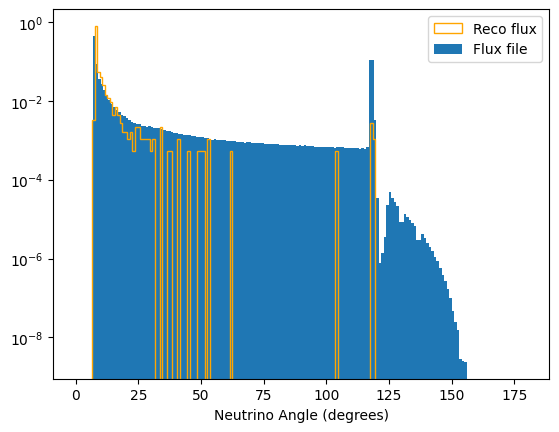

In [99]:
plt.bar(NuMI_angle_bins, NuMI_angle_dist/np.sum(NuMI_angle_dist), width=1, label="Flux file")
plt.hist(df['neutrino_angle'], histtype='step', bins = NuMI_angle_bins, color='orange', density=True, label="Reco flux") # weights = df['w_event_rate']
plt.yscale('log')
plt.xlabel('Neutrino Angle (degrees)')
plt.legend()
plt.show()

### Distance sampling

In [100]:
scale_mc = len(df['distance'].values)/sum(df['w_event_rate'])
scale_numi = np.sum(baseline_hist)

factor = scale_mc/scale_numi

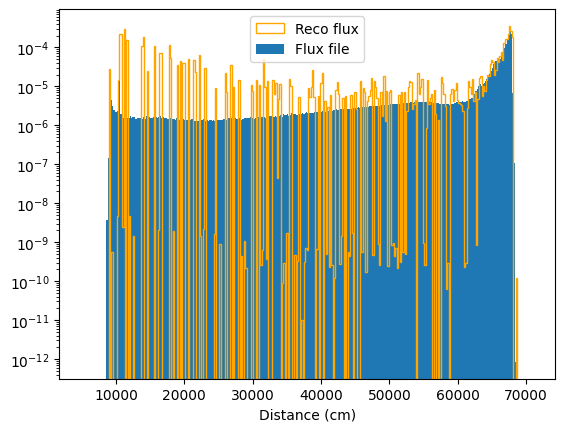

In [101]:
baseline_centres = (baseline_bins[1:] + baseline_bins[:-1]) / 2 * 100
plt.bar(baseline_centres, baseline_hist*factor, width=200, label="Flux file")

scale_mc = len(df['distance'].values)
scale_numi = np.sum(baseline_hist)

plt.hist(df['distance'].values, histtype='step', bins=baseline_centres, color='orange', density=True, weights = df['w_event_rate'], label="Reco flux") #, )
plt.yscale('log')
plt.xlabel('Distance (cm)')
plt.legend()

<!-- ## Printing these particles into a LArSoft-readable format -->

In [102]:
print = False
if print:
    printer = dn.printer.Printer(df, data_path='./output_files/NuMI')
    # printing a file in hepevt format
    printer.print_events_to_hepevt()
    # printing a file in hepmc3 format
    printer.print_events_to_hepmc3()
    # printing a file in hepevt legacy format
    # this format retains event weight!
    printer.print_events_to_hepevt_legacy()